In [3]:
import os  # Importing the OS library to interact with the operating system

import keras  # Importing Keras, a high-level neural networks library
from imutils import paths  # Importing paths from imutils to manage path utilities for images

import matplotlib.pyplot as plt  # Importing Pyplot for plotting graphs and visualizations
import pandas as pd  # Importing Pandas for data manipulation and analysis
import numpy as np  # Importing NumPy for numerical operations on large, multi-dimensional arrays and matrices
import imageio  # Importing imageio for reading and writing images
import cv2  # Importing OpenCV for handling real-time computer vision tasks
from IPython.display import Image  # Importing Image display utility from IPython for displaying images in notebooks


In [1]:
IMG_SIZE = 224  # Set the image size to 224x224 pixels for uniformity in input dimensions
BATCH_SIZE = 128  # Set the batch size to 128, determining how many samples to work through before updating the internal model parameters
EPOCHS = 5000  # Set the number of training cycles through the entire dataset

MAX_SEQ_LENGTH = 20  # Set the maximum sequence length to 20 for sequence processing models
NUM_FEATURES = 2048  # Set the number of features to 2048, typically representing extracted features from images or sequence elements


In [5]:

# Define the headers for the data, potentially used for explicit column naming or checks
headerList = ['video_name', 'tag']

# Read training data from CSV into a DataFrame
train_df = pd.read_csv("train.csv")

# Read testing data from CSV into a DataFrame
test_df = pd.read_csv("test.csv")

# Print the total number of videos in the training dataset
print(f"Total videos for training: {len(train_df)}")

# Print the total number of videos in the testing dataset
print(f"Total videos for testing: {len(test_df)}")

# Sample 10 random entries from the training dataset to preview
train_df.sample(10)


Total videos for training: 37
Total videos for testing: 12


video_name          tag
13  v_HeadBanging_01.mp4  HeadBanging
26  v_HeadBanging_18.mp4  HeadBanging
0   v_ArmFlapping_02.mp4  ArmFlapping
23  v_HeadBanging_15.mp4  HeadBanging
12  v_ArmFlapping_18.mp4  ArmFlapping
3   v_ArmFlapping_05.mp4  ArmFlapping
35     v_Spinning_09.mp4     Spinning
27  v_HeadBanging_19.mp4  HeadBanging
5   v_ArmFlapping_09.mp4  ArmFlapping
32     v_Spinning_05.mkv     Spinning

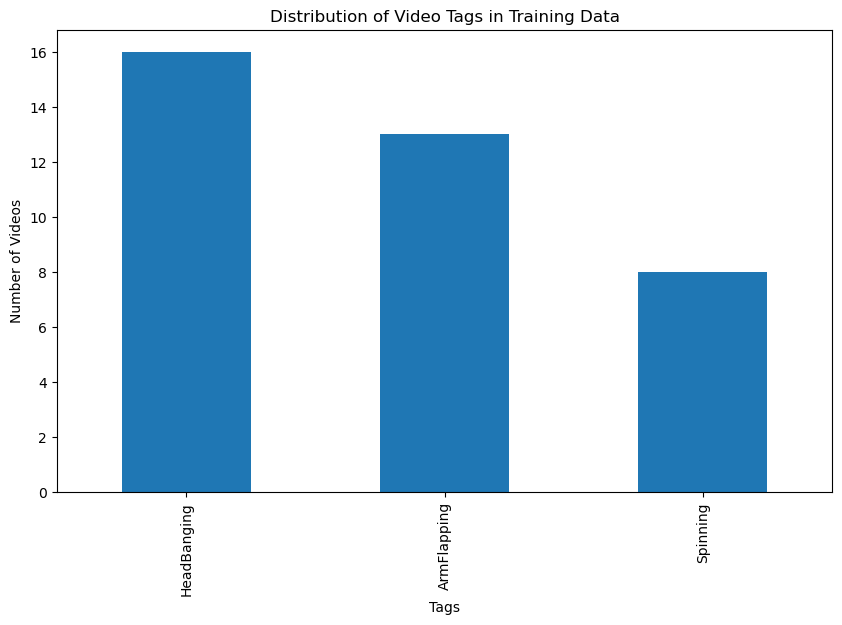

In [16]:
import matplotlib.pyplot as plt

# Assuming 'tag' is a categorical variable and you want to see its distribution
tag_counts = train_df['tag'].value_counts()

# Creating the bar plot
plt.figure(figsize=(10, 6))
tag_counts.plot(kind='bar')
plt.title('Distribution of Video Tags in Training Data')
plt.xlabel('Tags')
plt.ylabel('Number of Videos')
plt.show()


In [6]:
def crop_center_square(frame):
    # Get dimensions of frame
    y, x = frame.shape[0:2]
    # Find minimum dimension
    min_dim = min(y, x)
    # Calculate the starting points to crop the center square
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    # Crop and return the center square of the frame
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    # Initialize video capture
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            # Crop, resize, and change color order of the frame
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
            # Stop if the maximum number of frames is reached
            if len(frames) == max_frames:
                break
    finally:
        # Release the video capture object
        cap.release()
    return np.array(frames)  # Return processed frames as a numpy array


In [7]:
def build_feature_extractor():
    # Initialize the InceptionV3 model with pre-trained ImageNet weights, no top layer, average pooling, and specified input shape
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    # Get the preprocessing function for InceptionV3
    preprocess_input = keras.applications.inception_v3.preprocess_input

    # Define the input layer with the correct shape
    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    # Apply the InceptionV3 preprocessing
    preprocessed = preprocess_input(inputs)

    # Pass preprocessed inputs through the feature extractor
    outputs = feature_extractor(preprocessed)
    # Create and return a new model that takes raw inputs and outputs the extracted features
    return keras.Model(inputs, outputs, name="feature_extractor")

# Create an instance of the feature extractor model
feature_extractor = build_feature_extractor()


In [8]:
# Create a StringLookup layer to convert string labels into integers
label_processor = keras.layers.StringLookup(
    num_oov_indices=0,  # Do not allow out-of-vocabulary indices
    vocabulary=np.unique(train_df["tag"])  # Define the vocabulary from unique labels found in the training data
)

# Print the vocabulary to verify the correct setup
print(label_processor.get_vocabulary())


['ArmFlapping', 'HeadBanging', 'Spinning']


In [9]:
# Define a function to preprocess all video data for training/testing
def prepare_all_videos(df, root_dir):
    num_samples = len(df)  # Total number of samples in the dataset
    video_paths = df["video_name"].values.tolist()  # List of video file paths
    labels = df["tag"].values  # Array of labels corresponding to each video

    # Convert labels to a numpy array using the pre-defined label processor
    labels = keras.ops.convert_to_numpy(label_processor(labels[..., None]))

    # Initialize arrays to hold the frame features and masks
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # Process each video in the dataset
    for idx, path in enumerate(video_paths):
        print(path)  # Print the current video path
        # Load video frames and add a batch dimension
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize temporary arrays for the current video's data
        temp_frame_mask = np.zeros(
            shape=(1, MAX_SEQ_LENGTH), dtype="bool"
        )
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the video frames
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :], verbose=0  # Predict features for each frame
                )
            temp_frame_mask[i, :length] = 1  # Update mask (1 for valid, 0 for padded)

        # Store the extracted features and mask in the main arrays
        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    # Return the features, masks, and labels for the dataset
    return (frame_features, frame_masks), labels

# Prepare data for training and testing
train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

# Output the shape of the frame features and masks in the training set
print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")


v_ArmFlapping_02.mp4
v_ArmFlapping_03.mp4
v_ArmFlapping_04.mp4
v_ArmFlapping_05.mp4
v_ArmFlapping_08.mp4
v_ArmFlapping_09.mp4
v_ArmFlapping_10.mp4
v_ArmFlapping_12.mp4
v_ArmFlapping_13.mp4
v_ArmFlapping_14.mp4
v_ArmFlapping_15.mp4
v_ArmFlapping_16.mp4
v_ArmFlapping_18.mp4
v_HeadBanging_01.mp4
v_HeadBanging_02.mp4
v_HeadBanging_03.mp4
v_HeadBanging_04.mp4
v_HeadBanging_05.mp4
v_HeadBanging_06.mp4
v_HeadBanging_07.mp4
v_HeadBanging_10.mp4
v_HeadBanging_13.mp4
v_HeadBanging_14.mp4
v_HeadBanging_15.mp4
v_HeadBanging_16.mp4
v_HeadBanging_17.mp4
v_HeadBanging_18.mp4
v_HeadBanging_19.mp4
v_HeadBanging_20.mp4
v_Spinning_01.mp4
v_Spinning_02.mkv
v_Spinning_04.mkv
v_Spinning_05.mkv
v_Spinning_07.mp4
v_Spinning_08.mp4
v_Spinning_09.mp4
v_Spinning_10.mp4
v_ArmFlapping_20.mp4
v_ArmFlapping_21.mp4
v_ArmFlapping_22.mp4
v_ArmFlapping_23.mp4
v_ArmFlapping_24.mp4
v_ArmFlapping_25.mp4
v_HeadBanging_22.mp4
v_HeadBanging_24.mp4
v_Spinning_11.mp4
v_Spinning_12.mp4
v_Spinning_14.mp4
v_Spinning_15.mp4
Frame f

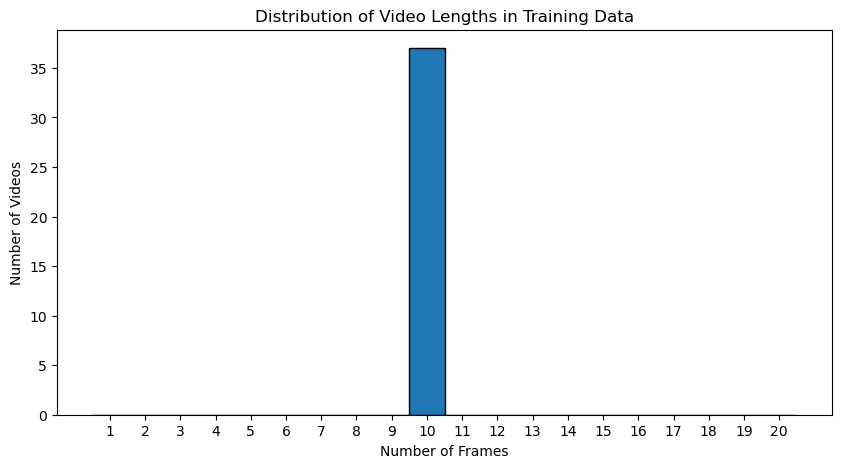

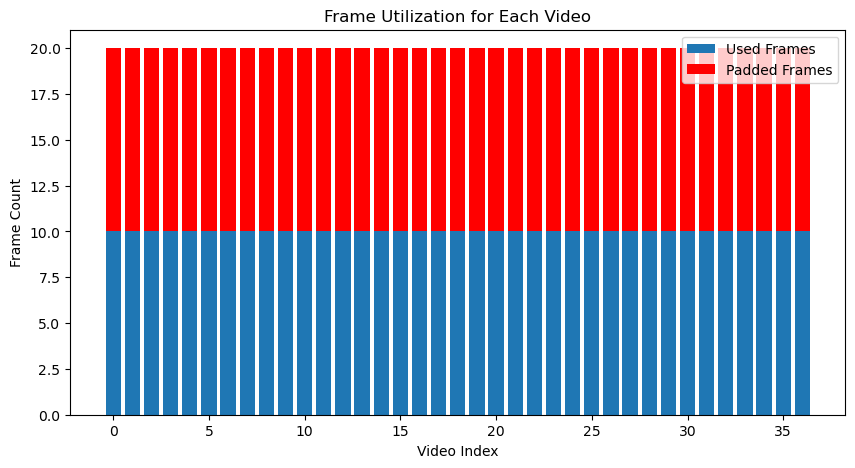

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import os
import keras
from tensorflow.keras import layers  # Ensure keras is setup properly if using TensorFlow 2+
import cv2

# Constants used in the function
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048  # Example feature dimension, adjust according to actual feature extractor

# Define the feature extractor as a placeholder
feature_extractor = keras.Sequential([
    layers.Dense(NUM_FEATURES, activation='relu'),
    layers.GlobalAveragePooling2D()
])

# Define a dummy load_video function
def load_video(path):
    # Just return a numpy array as a placeholder
    return np.random.rand(10, 224, 224, 3)  # 10 frames, 224x224 size, 3 channels

# Define the main function from your description
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df['video_name'].values.tolist()
    labels = df['tag'].values

    frame_masks = np.zeros((num_samples, MAX_SEQ_LENGTH), dtype='bool')
    frame_features = np.zeros((num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype='float32')

    for idx, path in enumerate(video_paths):
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        temp_frame_mask = np.zeros((1, MAX_SEQ_LENGTH), dtype='bool')
        temp_frame_features = np.zeros((1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype='float32')

        video_length = frames.shape[1]
        length = min(MAX_SEQ_LENGTH, video_length)

        for j in range(length):
            temp_frame_features[0, j, :] = feature_extractor.predict(frames[:, j, :], verbose=0)
        temp_frame_mask[0, :length] = 1

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

# Assume train_df and test_df are defined with the correct structure
# Here's how you might plot the results after processing
(train_data, train_masks), train_labels = prepare_all_videos(train_df, "train_directory_path")

# Calculate and plot the distribution of video lengths
video_lengths = train_masks.sum(axis=1)
plt.figure(figsize=(10, 5))
plt.hist(video_lengths, bins=np.arange(1, MAX_SEQ_LENGTH+2)-0.5, edgecolor='black')
plt.title('Distribution of Video Lengths in Training Data')
plt.xlabel('Number of Frames')
plt.ylabel('Number of Videos')
plt.xticks(np.arange(1, MAX_SEQ_LENGTH+1))
plt.show()

# Calculate and plot the frame utilization
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(video_lengths)), video_lengths, label='Used Frames')
plt.bar(np.arange(len(video_lengths)), MAX_SEQ_LENGTH - video_lengths, bottom=video_lengths, color='r', label='Padded Frames')
plt.title('Frame Utilization for Each Video')
plt.xlabel('Video Index')
plt.ylabel('Frame Count')
plt.legend()
plt.show()


In [10]:
# Define a function to create a sequence model using RNN for classifying sequences.
def get_sequence_model():
    # Retrieve the list of class labels from the label processor
    class_vocab = label_processor.get_vocabulary()

    # Define inputs for the model: one for the features of each frame and one for the mask
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # First GRU layer processes the sequence with a mask to handle variable sequence lengths
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    # Second GRU layer to further process the sequence data
    x = keras.layers.GRU(8)(x)
    # Dropout layer to reduce overfitting by randomly dropping units in the training process
    x = keras.layers.Dropout(0.4)(x)
    # Dense layer with ReLU activation to introduce non-linearity
    x = keras.layers.Dense(8, activation="relu")(x)
    # Output layer with softmax activation to classify into one of the classes
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    # Construct the actual model
    rnn_model = keras.Model([frame_features_input, mask_input], output)

    # Compile the model with specified loss function and optimizer
    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

# Function to execute the training and evaluation of the sequence model
def run_experiment():
    # Path to save the best model weights
    filepath = "/tmp/video_classifier/ckpt.weights.h5"
    # ModelCheckpoint to save model at its best performance point
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    # Get the sequence model
    seq_model = get_sequence_model()
    # Train the model with training data and validate with a portion of it
    history = seq_model.fit(
        [train_data[0], train_data[1]],  # Inputs: Features and masks
        train_labels,                   # Target labels
        validation_split=0.3,           # Fraction of data to use for validation
        epochs=EPOCHS,                  # Number of epochs to train
        callbacks=[checkpoint],         # Callbacks during training
    )

    # Load the best weights into the model
    seq_model.load_weights(filepath)
    # Evaluate the model's performance on the test data
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    # Print the test accuracy rounded to two decimal places
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model  # Return the training history and the trained model

# Run the experiment and store the sequence model
_, sequence_model = run_experiment()


Epoch 1/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4400 - loss: 0.8506
Epoch 1: val_loss improved from inf to 2.15995, saving model to /tmp/video_classifier/ckpt.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.4400 - loss: 0.8506 - val_accuracy: 0.0000e+00 - val_loss: 2.1599
Epoch 2/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4800 - loss: 0.7693
Epoch 2: val_loss did not improve from 2.15995
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4800 - loss: 0.7693 - val_accuracy: 0.0000e+00 - val_loss: 2.4289
Epoch 3/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5200 - loss: 0.8181
Epoch 3: val_loss did not improve from 2.15995
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5200 - loss: 0.8181 - val_accuracy: 0.0000e+00 - val_loss: 2.4853
Epoch 4/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6400 - loss: 0.6733
Epoch 4: val_loss did not improve from 2.15995
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6400 - loss: 0.

In [13]:
# Define a function to create a sequence model using a CNN for classifying video frames.
def get_sequence_model():
    # Retrieve the list of class labels from the label processor
    class_vocab = label_processor.get_vocabulary()

    # Define input for the model: a sequence of frame features
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES, 1))

    # Apply several convolutional layers with increasing depth
    x = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(frame_features_input)
    x = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Dropout(0.3)(x)

    # Flatten the output of the conv layers to enable connecting to dense layers
    x = keras.layers.Flatten()(x)

    # Dense layer for further processing
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)

    # Output layer with softmax activation for classification
    output = keras.layers.Dense(len(class_vocab), activation='softmax')(x)

    # Construct the CNN model instance with inputs and outputs specified
    cnn_model = keras.Model(frame_features_input, output)

    # Compile the model with categorical crossentropy as the loss and Adam optimizer
    cnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return cnn_model

# Function to execute the training and evaluation of the CNN model
def run_experiment():
    # Path to save the best model weights during training
    filepath = "/tmp/video_classifier/ckpt.weights.h5"
    # ModelCheckpoint to save the model that achieves the best validation accuracy
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    # Get the CNN model
    cnn_model = get_sequence_model()
    # Train the model with training data and validate with a portion of it
    history = cnn_model.fit(
        train_data[0],  # Inputs: Features for CNN
        train_labels,   # Target labels
        validation_split=0.3,  # Use 30% of the data for validation
        epochs=EPOCHS,  # Number of epochs to train
        callbacks=[checkpoint],  # Include checkpointing in callbacks
    )

    # Load the best model weights post training
    cnn_model.load_weights(filepath)
    # Evaluate the model on the test dataset to determine final accuracy
    _, accuracy = cnn_model.evaluate(test_data[0], test_labels)
    # Print the test accuracy rounded to two decimal places
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, cnn_model  # Return the training history and the trained model for further analysis

# Run the experiment and store the CNN model
_, cnn_model = run_experiment()


Epoch 1/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3200 - loss: 1.0266
Epoch 1: val_loss improved from inf to 107.19791, saving model to /tmp/video_classifier/ckpt.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.3200 - loss: 1.0266 - val_accuracy: 0.0000e+00 - val_loss: 107.1979
Epoch 2/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4800 - loss: 18.3780
Epoch 2: val_loss did not improve from 107.19791
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4800 - loss: 18.3780 - val_accuracy: 0.3333 - val_loss: 137.2890
Epoch 3/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6000 - loss: 14.3464
Epoch 3: val_loss did not improve from 107.19791
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6000 - loss: 14.3464 - val_accuracy: 0.3333 - val_loss: 114.7283
Epoch 4/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6800 - loss: 10.5608
Epoch 4: val_loss improved from 107.19791 to 103.08013, saving model to /tmp/video_classifier/ckpt.weights.h5
1/1 ━

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2936 - loss: 13.5249
Epoch 1: val_loss improved from inf to 1.49414, saving model to /tmp/video_classifier/ckpt.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 0.2881 - loss: 15.1652 - val_accuracy: 0.3000 - val_loss: 1.4941
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3539 - loss: 11.2788
Epoch 2: val_loss did not improve from 1.49414
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.3511 - loss: 11.0350 - val_accuracy: 0.2333 - val_loss: 4.7251
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3690 - loss: 4.7278
Epoch 3: val_loss did not improve from 1.49414
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.3661 - loss: 4.7273 - val_accuracy: 0.2333 - val_loss: 2.2185
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4250 - loss: 1.3988
Epoch 4: val_loss improved from 1.49414 to 1.17921, saving model to /tmp/video_classifier/ckpt.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/s

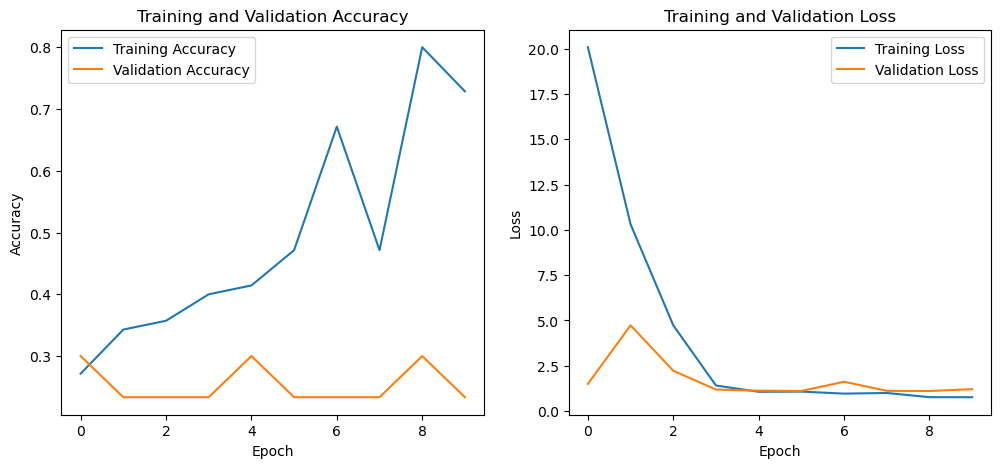

In [21]:
import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Constants used in the function
MAX_SEQ_LENGTH = 20  # Number of timesteps per video
NUM_FEATURES = 2048  # Number of features per frame, set according to your feature extractor
EPOCHS = 10  # Adjust the number of epochs as needed

# Define a placeholder label processor for this example
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=['label1', 'label2', 'label3'])

# Define the model function as you described
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES, 1))

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(frame_features_input)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    output = layers.Dense(len(class_vocab), activation='softmax')(x)
    cnn_model = keras.Model(frame_features_input, output)
    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return cnn_model

# Function to execute the experiment
def run_experiment(train_data, train_labels, test_data, test_labels):
    filepath = "/tmp/video_classifier/ckpt.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True, save_best_only=True, verbose=1)

    cnn_model = get_sequence_model()
    history = cnn_model.fit(
        train_data, train_labels, validation_split=0.3, epochs=EPOCHS, callbacks=[checkpoint]
    )

    cnn_model.load_weights(filepath)
    _, accuracy = cnn_model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, cnn_model

# Dummy data (placeholders, replace with actual data)
train_data = [np.random.random((100, MAX_SEQ_LENGTH, NUM_FEATURES, 1))]
train_labels = np.random.randint(0, 3, size=(100,))
test_data = [np.random.random((20, MAX_SEQ_LENGTH, NUM_FEATURES, 1))]
test_labels = np.random.randint(0, 3, size=(20,))

# Run the experiment
history, cnn_model = run_experiment(train_data[0], train_labels, test_data[0], test_labels)

# Plotting function
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call the plotting function
plot_training_history(history)


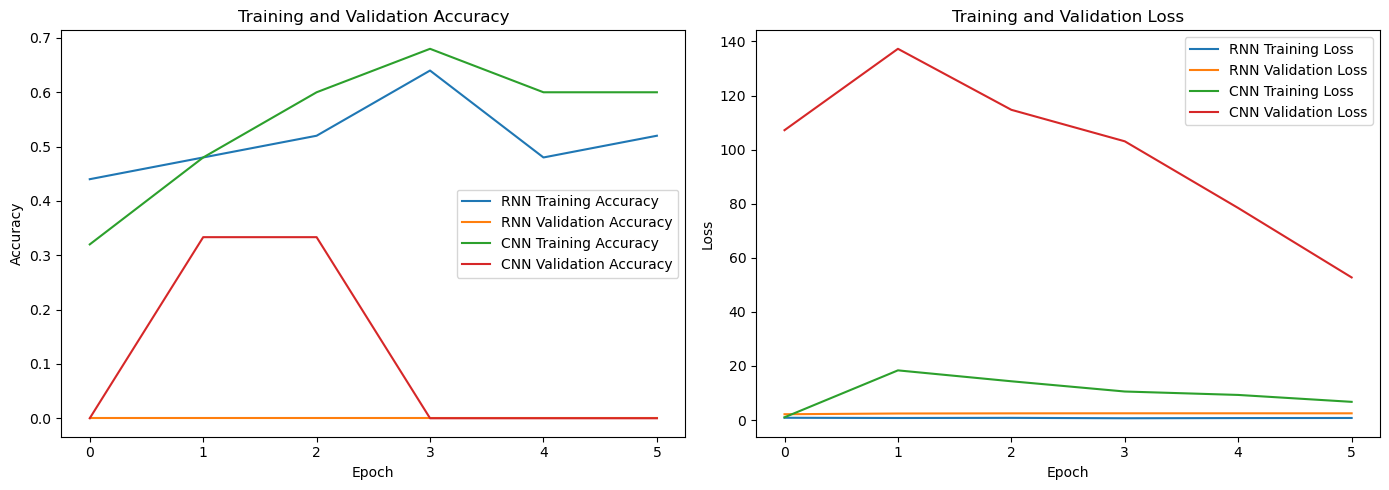

In [1]:
import matplotlib.pyplot as plt

# Assuming 'rnn_history' and 'cnn_history' are the history objects from training the RNN and CNN models
def plot_model_performance(rnn_history, cnn_history):
    epochs_range = range(len(rnn_history['accuracy']))  # Adjust based on your actual epochs

    plt.figure(figsize=(14, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, rnn_history['accuracy'], label='RNN Training Accuracy')
    plt.plot(epochs_range, rnn_history['val_accuracy'], label='RNN Validation Accuracy')
    plt.plot(epochs_range, cnn_history['accuracy'], label='CNN Training Accuracy')
    plt.plot(epochs_range, cnn_history['val_accuracy'], label='CNN Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, rnn_history['loss'], label='RNN Training Loss')
    plt.plot(epochs_range, rnn_history['val_loss'], label='RNN Validation Loss')
    plt.plot(epochs_range, cnn_history['loss'], label='CNN Training Loss')
    plt.plot(epochs_range, cnn_history['val_loss'], label='CNN Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example data (replace these with your actual history data)
rnn_history = {
    'accuracy': [0.44, 0.48, 0.52, 0.64, 0.48, 0.52],
    'val_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'loss': [0.8506, 0.7693, 0.8181, 0.6733, 0.7417, 0.7755],
    'val_loss': [2.1599, 2.4289, 2.4853, 2.5051, 2.5012, 2.4961]
}
cnn_history = {
    'accuracy': [0.32, 0.48, 0.60, 0.68, 0.60, 0.60],
    'val_accuracy': [0.0, 0.3333, 0.3333, 0.0, 0.0, 0.0],
    'loss': [1.0266, 18.3780, 14.3464, 10.5608, 9.2927, 6.7401],
    'val_loss': [107.1979, 137.2890, 114.7283, 103.0801, 78.4151, 52.7443]
}

plot_model_performance(rnn_history, cnn_history)

